In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from boruta import BorutaPy
from mrmr import mrmr_classif

from src.machinelearning import (
    ANNClassifier,
    evaluate_ann,
    evaluate_sklearn,
    get_predictions,
    train_ann,
    train_decisiontree,
    train_skoperules,
    train_xgboost,
)
from src.ml2rules import TreeRuler, ml2tree, sample_from_df
from src.utils import get_cc_mat, get_dataset, non_stratify_split, stratify_split

In [4]:
def get_value_counts(df: pd.DataFrame, target: str) -> None:
    """ Display the value counts of the label column in the dataframe. """
    display(
        pd.DataFrame(
        data=[df[target].value_counts(normalize=True).round(4), df[target].value_counts()],
        index=["percentage", "absolute"]    
    ).T
    )


### Data loading

In [18]:
file_name = '../data/Parameters_80_stability.csv'

df = pd.read_csv(file_name, index_col=0)
df.reset_index(drop=True, inplace=True)
print(f'Dataset shape: {df.shape}')

get_value_counts(df, 'Stability')

Dataset shape: (372, 1411)


,percentage,absolute
0,0.6801,253.0
1,0.3199,119.0


### Train - Test data split

In [19]:
X_train, X_test, y_train, y_test = stratify_split(data=df, train_size=0.8, target="Stability")

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print('Training set value counts:')
get_value_counts(train_df, 'Stability')

print('Test set value counts:')
get_value_counts(test_df, 'Stability')

Traininig set shape: (297, 1410)
Test set shape: (75, 1410)
Training set value counts:


,percentage,absolute
0,0.6801,202.0
1,0.3199,95.0


Test set value counts:


,percentage,absolute
0,0.68,51.0
1,0.32,24.0


### Feature Selection

In [20]:
K = int(100)
print(f"***Number of features to select: {K}")
selected_features_mrmr = mrmr_classif(X=train_df.drop("Stability", axis=1), y=train_df["Stability"], K=K)

# keep only selected features
X_train = X_train[selected_features_mrmr]
X_test = X_test[selected_features_mrmr]
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(f'Training set shape: {train_df.shape}')
print(f'Test set shape: {test_df.shape}')

***Number of features to select: 100


100%|██████████| 100/100 [00:16<00:00,  6.11it/s]

Training set shape: (297, 101)
Test set shape: (75, 101)


# Machine Learning

### Decision Tree - iSHRUNCK

In [ ]:
cart_model = train_decisiontree(X_train, y_train, scoring='matthews_corrcoef', n_trials=100)

In [26]:
cart_model

DecisionTreeClassifier(max_depth=19, max_features='log2', min_samples_leaf=10,
                       min_samples_split=11)

In [27]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(cart_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(cart_model, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.8687
Precision: 0.8784
Recall: 0.6842
F1 score: 0.7692
ROC AUC score: 0.8198
MCC: 0.6898

*** Evaluation on test set:
Accuracy: 0.7733
Precision: 0.7059
Recall: 0.5000
F1 score: 0.5854
ROC AUC score: 0.7010
MCC: 0.4479


In [29]:
ruler = TreeRuler(df=train_df, tree_clf=cart_model, target="Stability")
ruler.get_rules()
print(f'Number of rules: {len(ruler.rules)}')
ruler.rules

Number of rules: 17


['if (Gamma_ALATA_L > 0.315) and (Gamma_TPI <= 0.893) and (sigma_km_substrate_SBP > 0.099) and (sigma_km_substrate1_NADH2_u6cm > 0.103) and (sigma_km_product2_SUCOAACTm <= 0.681) then class: 0 (proba: 100.0%) | based on 75 samples',
 'if (Gamma_ALATA_L <= 0.315) and (sigma_km_substrate2_UBICRED > 0.265) and (sigma_km_product2_GNK <= 0.687) and (sigma_km_substrate1_NADH2_u6cm > 0.105) then class: 1 (proba: 100.0%) | based on 29 samples',
 'if (Gamma_ALATA_L > 0.315) and (Gamma_TPI > 0.893) and (sigma_km_product2_MDH <= 0.741) and (sigma_km_substrate1_GAPD > 0.22) and (sigma_km_substrate1_AGTi <= 0.459) and (sigma_km_substrate2_UBICRED > 0.504) then class: 1 (proba: 87.5%) | based on 16 samples',
 'if (Gamma_ALATA_L <= 0.315) and (sigma_km_substrate2_UBICRED > 0.265) and (sigma_km_product2_GNK <= 0.687) and (sigma_km_substrate1_NADH2_u6cm <= 0.105) then class: 1 (proba: 93.75%) | based on 16 samples',
 'if (Gamma_ALATA_L > 0.315) and (Gamma_TPI > 0.893) and (sigma_km_product2_MDH > 0.741

In [32]:
rule = ruler.get_rule_constraints(1)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df, 'Stability')

['Gamma_ALATA_L<=0.315', 'sigma_km_substrate2_UBICRED>0.265', 'sigma_km_product2_GNK<=0.687', 'sigma_km_substrate1_NADH2_u6cm>0.105']
Number of parameter sets following the rule: 10


,percentage,absolute
1,0.8,8.0
0,0.2,2.0


##### Skope - Rules

In [ ]:
skope_rules_clf = train_skoperules(X_train, y_train, scoring='matthews_corrcoef', n_iter=100)

In [ ]:
skope_rules_clf

In [35]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(skope_rules_clf, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(skope_rules_clf, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.8249
Precision: 0.6972
Recall: 0.8000
F1 score: 0.7451
ROC AUC score: 0.8183
MCC: 0.6161

*** Evaluation on test set:
Accuracy: 0.6267
Precision: 0.4444
Recall: 0.6667
F1 score: 0.5333
ROC AUC score: 0.6373
MCC: 0.2563


In [36]:
# Print skope-rules rules
print(f'*** Number of rules {len(skope_rules_clf.rules_)}')

# Get rules
for i in skope_rules_clf.rules_:
    print(i)

*** Number of rules 3
('sigma_km_substrate1_GS > 0.5142368525266647 and Gamma_ME1m <= 8.075000152985012e-07 and sigma_km_substrate1_MALtm <= 0.5063199102878571', (0.8269230769230769, 0.5733333333333334, 2))
('sigma_km_substrate1_AGTi <= 0.8319400250911713 and Gamma_H2Ot > 205.59380340576172 and sigma_km_product1_GMPS2 <= 0.5702075958251953', (0.9545454545454546, 0.5121951219512195, 2))
('sigma_km_product_VALt5m <= 0.3759643882513046 and Gamma_H2Ot <= 205.59380340576172 and sigma_km_substrate1_PHETRA > 0.37685295939445496', (0.5365853658536586, 0.29333333333333333, 2))


In [40]:
_ = test_df[test_df['sigma_km_substrate1_AGTi'] <= 0.8319400250911713]
_ = _[_['Gamma_H2Ot'] > 205.59380340576172]
_ = _[_['sigma_km_product1_GMPS2'] <= 0.5702075958251953]

get_value_counts(_, 'Stability')

,percentage,absolute
1,0.8571,12.0
0,0.1429,2.0


##### XGBoost

In [41]:
xgb_model = train_xgboost(X_train, y_train, scoring='matthews_corrcoef', n_trials=100)

In [ ]:
xgb_model

In [43]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(xgb_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(xgb_model, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.9899
Precision: 0.9894
Recall: 0.9789
F1 score: 0.9841
ROC AUC score: 0.9870
MCC: 0.9767

*** Evaluation on test set:
Accuracy: 0.8000
Precision: 0.7368
Recall: 0.5833
F1 score: 0.6512
ROC AUC score: 0.7426
MCC: 0.5205


In [ ]:
xgb_preds = xgb_model.predict(X_train)
xgb2tree = ml2tree(X_train, xgb_preds, scoring='matthews_corrcoef', n_trials=100)

In [ ]:
xgb2tree

In [45]:
evaluate_sklearn(xgb2tree, X_test, y_test)

Accuracy: 0.7333
Precision: 0.5833
Recall: 0.5833
F1 score: 0.5833
ROC AUC score: 0.6936
MCC: 0.3873


In [47]:
ruler = TreeRuler(df=train_df, tree_clf=xgb2tree, target="Stability")
ruler.get_rules()
ruler.rules

['if (Gamma_TPI > 0.641) and (sigma_km_substrate_NADHtrm > 0.057) and (sigma_km_substrate1_AGTi > 0.367) and (sigma_km_substrate2_GK1 > 0.094) and (sigma_km_substrate3_GMPS2 > 0.159) and (sigma_km_substrate1_PHETRA > 0.122) then class: 0 (proba: 100.0%) | based on 103 samples',
 'if (Gamma_TPI <= 0.641) and (sigma_km_product2_GNK <= 0.704) and (sigma_km_product_GLYtm <= 0.852) and (sigma_km_substrate_DHQTi <= 0.995) then class: 1 (proba: 100.0%) | based on 38 samples',
 'if (Gamma_TPI > 0.641) and (sigma_km_substrate_NADHtrm > 0.057) and (sigma_km_substrate1_AGTi <= 0.367) and (sigma_km_product2_ACSm > 0.259) and (sigma_km_product2_ALCD26xi <= 0.801) and (sigma_km_product2_MDH > 0.209) then class: 0 (proba: 100.0%) | based on 32 samples',
 'if (Gamma_TPI > 0.641) and (sigma_km_substrate_NADHtrm > 0.057) and (sigma_km_substrate1_AGTi > 0.367) and (sigma_km_substrate2_GK1 > 0.094) and (sigma_km_substrate3_GMPS2 <= 0.159) then class: 0 (proba: 76.92%) | based on 13 samples',
 'if (Gamma_T

In [57]:
rule = ruler.get_rule_constraints(1)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df, 'Stability')

['Gamma_TPI<=0.641', 'sigma_km_product2_GNK<=0.704', 'sigma_km_product_GLYtm<=0.852', 'sigma_km_substrate_DHQTi<=0.995']
Number of parameter sets following the rule: 10


,percentage,absolute
1,0.8,8.0
0,0.2,2.0


### Exlainable Machine Learning

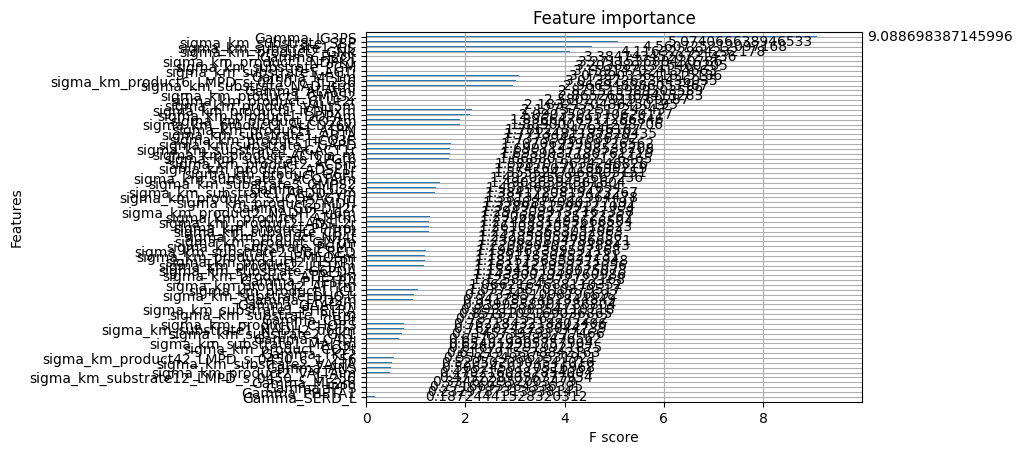

In [61]:
xgb.plot_importance(xgb_model, importance_type='gain')
plt.show()

2024-10-01 12:32:27.742377: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 12:32:27.756862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 12:32:27.773294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 12:32:27.777984: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 12:32:27.791762: I tensorflow/core/platform/cpu_feature_guar

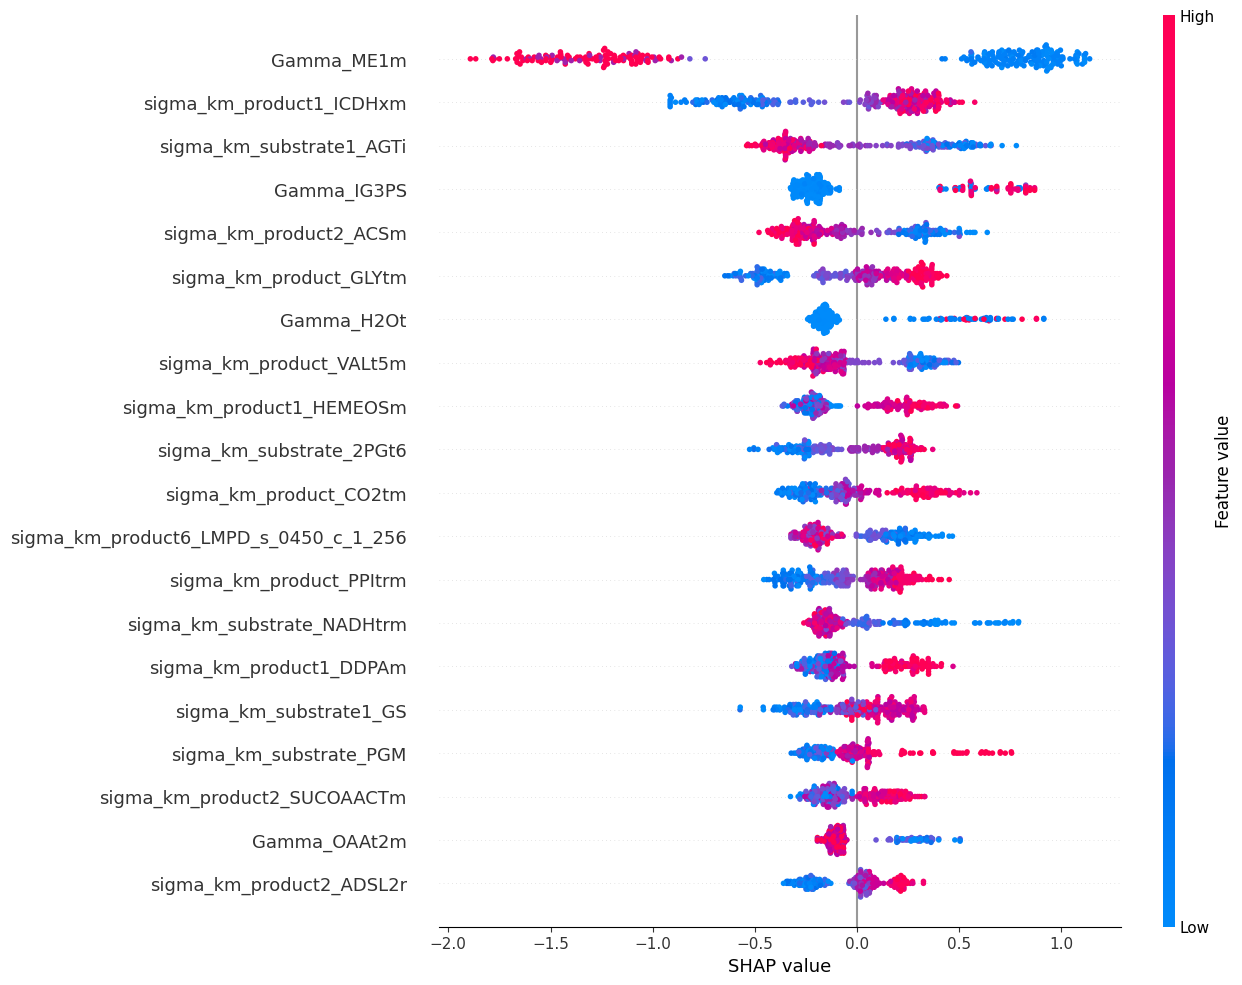

In [62]:
import shap

# Create a TreeExplainer for the xgb_model
explainer = shap.TreeExplainer(xgb_model)
# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)
# Display the SHAP summary plot

fig = plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="dot", show=False)
plt.gcf().set_size_inches(20,10)
plt.xlabel("SHAP value")
plt.show()

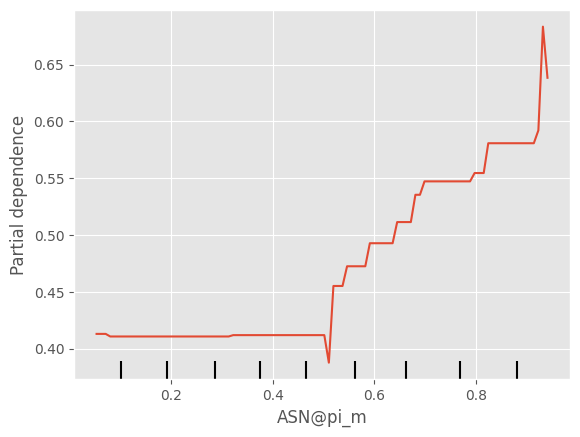

In [24]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=['ASN@pi_m'])
plt.show()